<a href="https://colab.research.google.com/github/aldiekawahyu/manajerku-inventory-management/blob/main/demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data
Source: https://www.kaggle.com/felixzhao/productdemandforecasting \\
Steps:
1. Go to kaggle account and click **'Create New API Token'**. A kaggle.json file will be downloaded to your local machine.
1. Upload the kaggle.json file into into colab
1. Download the dataset from kaggle and unzip it

In [49]:
import os

! pip install -q kaggle
from google.colab import files
files.upload()
try:
  os.makedirs('~/.kaggle')    
  print('Directory created successfully')
except:
  pass
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d felixzhao/productdemandforecasting/
! unzip productdemandforecasting.zip

Saving kaggle.json to kaggle (1).json
productdemandforecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  productdemandforecasting.zip
replace Historical Product Demand.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Historical Product Demand.csv  


# Start Exploratory Data Analysis

## Check Missing Value and Object Type

First, open the csv file as pandas dataframe file then check if there are missing values.

In [108]:
import pandas as pd

df = pd.read_csv('Historical Product Demand.csv')
print('Dataframe length: {}'.format(len(df)))
df.head()

Dataframe length: 1048575


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


Check the number of missing value per column.

In [109]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

Proportion of missing value per column.

In [110]:
df.isnull().sum()/len(df)

Product_Code        0.000000
Warehouse           0.000000
Product_Category    0.000000
Date                0.010718
Order_Demand        0.000000
dtype: float64

It can be seen that there are missing values in *Date* column. We are going to handle this by **dropping rows containing missing value**, because date is non-numerical value thus it cannot be imputed.

In [111]:
print('Length before dropping: {}'.format(len(df)))
df = df.dropna(axis='rows')
print('Length after dropping: {}'.format(len(df)))

Length before dropping: 1048575
Length after dropping: 1037336


Next, we will check the type of each column of the data frame and convert the type of *Order_Demand* column if it is non-numeric.

In [112]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

We see that *Order_Demand* column is not a float, so there must be something about the number. Let's try to convert it into float.

In [113]:
try:
  df["Order_Demand"] = pd.to_numeric(df["Order_Demand"], downcast="float")
  print('Conversion succeeded')
except ValueError as e:
  print('Cannot do conversion: ',e)

Cannot do conversion:  Unable to parse string "(1)" at position 112289


We see an indication that several numbers in *Order_Demand* column are written in parentheses, so we need to remove the parentheses.

In [114]:
def remove_parentheses(x):
  import re
  return re.sub('[()]', '', x)

df["Order_Demand"] = df["Order_Demand"].apply(remove_parentheses)

Lets try doing conversion again.

In [115]:
try:
  df["Order_Demand"] = pd.to_numeric(df["Order_Demand"], downcast="float")
  print('Conversion succeeded')
except ValueError as e:
  print('Cannot do conversion: ',e)

df.dtypes

Conversion succeeded


Product_Code         object
Warehouse            object
Product_Category     object
Date                 object
Order_Demand        float32
dtype: object

The *Order_Demand* column is already converted to float. Next we are going to convert *Date* column to datetime.

In [116]:
df.Date = pd.to_datetime(df.Date)
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand               float32
dtype: object

In [117]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100.0
1,Product_0979,Whse_J,Category_028,2012-01-19,500.0
2,Product_0979,Whse_J,Category_028,2012-02-03,500.0
3,Product_0979,Whse_J,Category_028,2012-02-09,500.0
4,Product_0979,Whse_J,Category_028,2012-03-02,500.0


The *Date* column is already converted to datetime. Lets check the first and the last date of the dataset.

In [118]:
first_date = df['Date'].min()
last_date = df['Date'].max()

print('First date: %s' % first_date)
print('Last date: %s' % last_date)

First date: 2011-01-08 00:00:00
Last date: 2017-01-09 00:00:00


## Get Unique Value of *Product_Code*,	*Warehouse* and	*Product_Category*

In [119]:
# Products
product_code = sorted(df['Product_Code'].unique().tolist())
print('Number of product: {}'.format(len(product_code)))

# Warehouses
warehouse = sorted(df['Warehouse'].unique().tolist())
print('Number of warehouse: {}'.format(len(warehouse)))

# Product category
product_category = sorted(df['Product_Category'].unique().tolist())
print('Number of product category: {}'.format(len(product_category)))

Number of product: 2160
Number of warehouse: 4
Number of product category: 33


## Check Total Number of Product per Category

In [120]:
sample = 10
product_per_category = df.groupby(['Product_Category'])['Product_Code'].nunique()
print("Total number of product per each category for first {} category \n{}".format(sample, product_per_category[:sample]))

Total number of product per each category for first 10 category 
Product_Category
Category_001    278
Category_002      1
Category_003     12
Category_004      1
Category_005    185
Category_006    112
Category_007    141
Category_008      7
Category_009    102
Category_010      7
Name: Product_Code, dtype: int64


## Check Total Date (or days) per Product

In [121]:
days_per_product = df.groupby(['Product_Code'])['Date'].nunique()
print("Total number of days per product: \n{}".format(days_per_product))

Total number of days per product: 
Product_Code
Product_0001    469
Product_0002    341
Product_0003    275
Product_0004    267
Product_0005     52
               ... 
Product_2168    647
Product_2169    571
Product_2170    173
Product_2171    509
Product_2172     46
Name: Date, Length: 2160, dtype: int64


We can see that each product has a different amount of record.

## Inspect the Demand Aggregate of Each Product Category

In [122]:
df.groupby(["Product_Category", "Product_Code"]).agg({"Order_Demand": ["sum", "mean", "median", "std"]})

Order_Demand                                     
                                       sum          mean   median           std
Product_Category Product_Code                                                  
Category_001     Product_0256        371.0      1.641593      1.0      1.493644
                 Product_0257        177.0      1.638889      1.0      0.999611
                 Product_0258        298.0      2.083916      2.0      1.859488
                 Product_0259        205.0      2.277778      2.0      1.735471
                 Product_0260       1729.0     11.761905      3.0     16.716546
...                                    ...           ...      ...           ...
Category_032     Product_1101    3394000.0  14082.987305  10000.0  17006.658040
Category_033     Product_1282    9710000.0  21108.695312  20000.0  15091.194479
                 Product_1361   28190000.0  29334.027344  10000.0  35133.284570
                 Product_1362    1290000.0  10000.000000  10000.0   1250.000000
                 Product_1363    3420000.0  11438.126953  10000.0   7254.159962

[2160 rows x 4 columns]

## Sort Data based on the Date

In [220]:
df = df.sort_values(by="Date")
print('Dataframe length: {}'.format(len(df)))
df.head()

Dataframe length: 1036696


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
130870,Product_2166,Whse_S,Category_024,2012-01-01,2.0
77217,Product_1343,Whse_S,Category_019,2012-01-02,5000.0
77218,Product_1433,Whse_S,Category_019,2012-01-02,2000.0
75883,Product_1432,Whse_S,Category_019,2012-01-02,30000.0
75882,Product_1342,Whse_S,Category_019,2012-01-02,50000.0


Check behavior of the date.

In [221]:
df.Date.unique()[:50]

array(['2012-01-01T00:00:00.000000000', '2012-01-02T00:00:00.000000000',
       '2012-01-03T00:00:00.000000000', '2012-01-04T00:00:00.000000000',
       '2012-01-05T00:00:00.000000000', '2012-01-06T00:00:00.000000000',
       '2012-01-08T00:00:00.000000000', '2012-01-09T00:00:00.000000000',
       '2012-01-10T00:00:00.000000000', '2012-01-11T00:00:00.000000000',
       '2012-01-12T00:00:00.000000000', '2012-01-13T00:00:00.000000000',
       '2012-01-15T00:00:00.000000000', '2012-01-16T00:00:00.000000000',
       '2012-01-17T00:00:00.000000000', '2012-01-18T00:00:00.000000000',
       '2012-01-19T00:00:00.000000000', '2012-01-20T00:00:00.000000000',
       '2012-01-21T00:00:00.000000000', '2012-01-22T00:00:00.000000000',
       '2012-01-23T00:00:00.000000000', '2012-01-24T00:00:00.000000000',
       '2012-01-25T00:00:00.000000000', '2012-01-26T00:00:00.000000000',
       '2012-01-27T00:00:00.000000000', '2012-01-28T00:00:00.000000000',
       '2012-01-29T00:00:00.000000000', '2012-01-30

We see that the records for 2011 are too few (so many missing dates). So we took data starting from January 2012 and later fill missing dates with zero.

In [222]:
df = df.loc[df.Date.dt.year >= 2012, :]
print('Dataframe length: {}'.format(len(df)))
df.head()

Dataframe length: 1036696


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
130870,Product_2166,Whse_S,Category_024,2012-01-01,2.0
77217,Product_1343,Whse_S,Category_019,2012-01-02,5000.0
77218,Product_1433,Whse_S,Category_019,2012-01-02,2000.0
75883,Product_1432,Whse_S,Category_019,2012-01-02,30000.0
75882,Product_1342,Whse_S,Category_019,2012-01-02,50000.0


In [223]:
df.Date.unique()[:20]

array(['2012-01-01T00:00:00.000000000', '2012-01-02T00:00:00.000000000',
       '2012-01-03T00:00:00.000000000', '2012-01-04T00:00:00.000000000',
       '2012-01-05T00:00:00.000000000', '2012-01-06T00:00:00.000000000',
       '2012-01-08T00:00:00.000000000', '2012-01-09T00:00:00.000000000',
       '2012-01-10T00:00:00.000000000', '2012-01-11T00:00:00.000000000',
       '2012-01-12T00:00:00.000000000', '2012-01-13T00:00:00.000000000',
       '2012-01-15T00:00:00.000000000', '2012-01-16T00:00:00.000000000',
       '2012-01-17T00:00:00.000000000', '2012-01-18T00:00:00.000000000',
       '2012-01-19T00:00:00.000000000', '2012-01-20T00:00:00.000000000',
       '2012-01-21T00:00:00.000000000', '2012-01-22T00:00:00.000000000'],
      dtype='datetime64[ns]')

## Pivot Table

In [224]:
import numpy as np
df_pivot = pd.pivot_table(df, values='Order_Demand', index=['Date'],
                    columns=['Product_Code'], aggfunc=np.sum)
df_pivot = df_pivot.fillna(0) # Fill NaN value with zero
print(df_pivot)

Product_Code  Product_0001  Product_0002  ...  Product_2171  Product_2172
Date                                      ...                            
2012-01-01             0.0           0.0  ...           0.0           0.0
2012-01-02             0.0           0.0  ...           0.0           0.0
2012-01-03          1000.0           0.0  ...           0.0           0.0
2012-01-04           200.0           0.0  ...           0.0           0.0
2012-01-05           100.0           0.0  ...           0.0           0.0
...                    ...           ...  ...           ...           ...
2017-01-03             0.0           0.0  ...           0.0           0.0
2017-01-04             0.0           0.0  ...           0.0           0.0
2017-01-05             0.0           0.0  ...           0.0           0.0
2017-01-06             0.0           0.0  ...           0.0           0.0
2017-01-09             0.0           0.0  ...           0.0           0.0

[1687 rows x 2160 columns]


In [225]:
first_date_new = df_pivot.index.min()
last_date_new = df_pivot.index.max()
idx = pd.date_range(first_date_new, last_date_new)

print('First date: %s' % first_date_new)
print('Last date: %s' % last_date_new)

First date: 2012-01-01 00:00:00
Last date: 2017-01-09 00:00:00


We are going to **fill missing dates** in *df_pivot* with zero for every column.

In [226]:
df_pivot = df_pivot.asfreq('D').fillna(0)
print(df_pivot)

Product_Code  Product_0001  Product_0002  ...  Product_2171  Product_2172
Date                                      ...                            
2012-01-01             0.0           0.0  ...           0.0           0.0
2012-01-02             0.0           0.0  ...           0.0           0.0
2012-01-03          1000.0           0.0  ...           0.0           0.0
2012-01-04           200.0           0.0  ...           0.0           0.0
2012-01-05           100.0           0.0  ...           0.0           0.0
...                    ...           ...  ...           ...           ...
2017-01-05             0.0           0.0  ...           0.0           0.0
2017-01-06             0.0           0.0  ...           0.0           0.0
2017-01-07             0.0           0.0  ...           0.0           0.0
2017-01-08             0.0           0.0  ...           0.0           0.0
2017-01-09             0.0           0.0  ...           0.0           0.0

[1836 rows x 2160 columns]


In [227]:
df_pivot.to_csv('Demand_per_product.csv')

## Time Series Plot

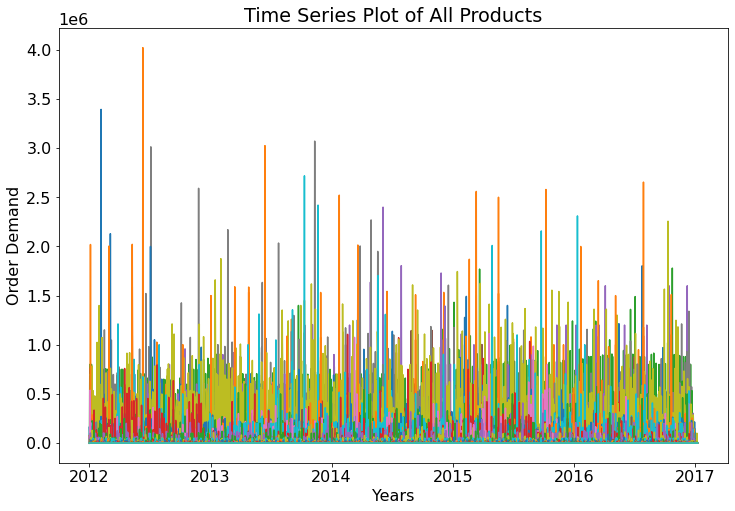

In [236]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

fig,ax = plt.subplots(figsize=(12,8))
for column in df_pivot:
    plt.plot(df_pivot.index, df_pivot[column])
ax.set_title('Time Series Plot of All Products')
ax.set_xlabel('Years')
ax.set_ylabel('Order Demand')
plt.show()

## Data Features

In [238]:
def time_feature(df_pivot):
  df_pivot['day'] = df_pivot.index.day
  df_pivot['month'] = df_pivot.index.month
  df_pivot['year'] = df_pivot.index.year
  df_pivot['day_of_week'] = df_pivot.index.dayofweek
  return df_pivot

In [240]:
df_pivot_feature = time_feature(df_pivot)
df_pivot_feature

Product_Code,Product_0001,Product_0002,Product_0003,Product_0004,Product_0005,Product_0006,Product_0007,Product_0008,Product_0009,Product_0010,Product_0011,Product_0012,Product_0013,Product_0014,Product_0015,Product_0016,Product_0017,Product_0018,Product_0019,Product_0020,Product_0021,Product_0022,Product_0023,Product_0024,Product_0025,Product_0026,Product_0027,Product_0028,Product_0029,Product_0030,Product_0031,Product_0032,Product_0033,Product_0034,Product_0035,Product_0036,Product_0037,Product_0038,Product_0039,Product_0040,...,Product_2137,Product_2138,Product_2139,Product_2140,Product_2141,Product_2142,Product_2143,Product_2144,Product_2145,Product_2146,Product_2147,Product_2148,Product_2149,Product_2150,Product_2151,Product_2152,Product_2153,Product_2154,Product_2155,Product_2156,Product_2157,Product_2158,Product_2159,Product_2160,Product_2161,Product_2162,Product_2163,Product_2164,Product_2165,Product_2166,Product_2167,Product_2168,Product_2169,Product_2170,Product_2171,Product_2172,day,month,year,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2012,6
2012-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,2,1,2012,0
2012-01-03,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1164.0,200.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,1,2012,1
2012-01-04,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1800.0,2750.0,2410.0,0.0,20.0,1328.0,1800.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,390.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,4,1,2012,2
2012-01-05,100.0,0.0,0.0,0.0,0.0,0.0,0.0,3000.0,0.0,0.0,1400.0,11000.0,0.0,0.0,1000.0,100.0,200.0,100.0,0.0,1100.0,500.0,0.0,0.0,0.0,1600.0,0.0,50.0,0.0,0.0,0.0,8300.0,0.0,4000.0,0.0,0.0,2000.0,2000.0,0.0,200.0,0.0,...,0.0,300.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,11.0,1047.0,0.0,0.0,0.0,0.0,0.0,5,1,2012,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1,2017,3
2017-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1,2017,4
2017-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,